In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go

# Проведем разведочный анализ и построим рекомендательную систему на основе датасета фильмов и сериалов стримингового сервиса Netflix
(https://www.kaggle.com/datasets/shivamb/netflix-shows)

библиотеки для анализа данных (pandas и numpy), а также библиотеки для визуализации matplotlib и seaborn

In [ ]:
!wget 'https://drive.google.com/uc?id=1cunfb3ij7N1aRIhmlx6dXhiQfpecphrc' -O netflix_titles.csv

--2023-07-06 15:08:04--  https://drive.google.com/uc?id=1cunfb3ij7N1aRIhmlx6dXhiQfpecphrc
Resolving drive.google.com (drive.google.com)... 142.251.171.100, 142.251.171.101, 142.251.171.102, ...
Connecting to drive.google.com (drive.google.com)|142.251.171.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/us32a23fo1tfec3adtv18rv6labk5msr/1688656050000/14904333240138417226/*/1cunfb3ij7N1aRIhmlx6dXhiQfpecphrc?uuid=e80e2fa8-78e4-49d7-971f-9f46ccdf65c9 [following]
--2023-07-06 15:08:05--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/us32a23fo1tfec3adtv18rv6labk5msr/1688656050000/14904333240138417226/*/1cunfb3ij7N1aRIhmlx6dXhiQfpecphrc?uuid=e80e2fa8-78e4-49d7-971f-9f46ccdf65c9
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to do

In [ ]:
df = pd.read_csv('netflix_titles.csv')
df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [ ]:
df.columns

Index(['show_id', 'type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description'],
      dtype='object')

## Посмотрим на пропуски в датасете

In [ ]:
df.isna().any()

show_id         False
type            False
title           False
director         True
cast             True
country          True
date_added       True
release_year    False
rating           True
duration        False
listed_in       False
description     False
dtype: bool

Пропуски есть. Больше всего их в колонке director. Однако это не помешает нашему дальнейшему анализу.

Поделим наш датасет на фильмы и сериалы, посмотрим чего больше фильмов или сериалов.

In [ ]:
movies = df[df['type'] == 'Movie']
tvshows = df[df['type'] == 'TV Show']

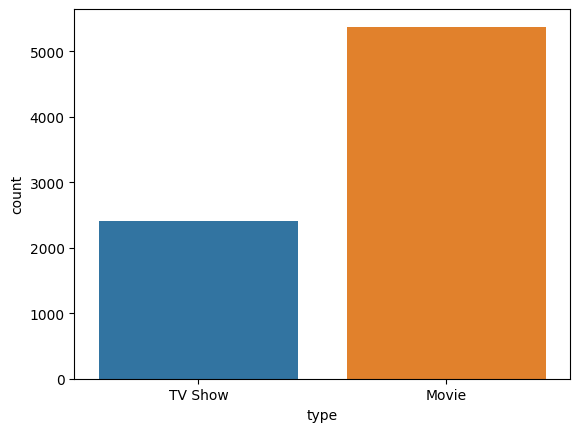

In [ ]:
ax = sns.countplot(x = 'type', data = df)

## Какой месяц наиболее привлекательный для релиза контента?
Обратимся к колонке date_added

In [ ]:
#у datе_added были пропуски. удалим их и перезапишем эти значения в новую переменную
df_date=df[['date_added']].dropna()
df_date

,date_added
0,"August 14, 2020"
1,"December 23, 2016"
2,"December 20, 2018"
3,"November 16, 2017"
4,"January 1, 2020"
...,...
7782,"October 19, 2020"
7783,"March 2, 2019"
7784,"September 25, 2020"
7785,"October 31, 2020"


In [ ]:
df_date['year'] = df_date['date_added'].apply(lambda x: x.split(', ')[-1])
df_date['month'] = df_date['date_added'].apply(lambda x: x.strip().split(' ')[0]) #разобьем колонку на месяц и год

In [ ]:
#преобразуем df_date в сводную таблицуб заполним "перерывы" и определим порядок отображение месяцев
months_order = ['December', 'November', 'October', 'September', 'August', 'July', 'June', 'May', 'April', 'March', 'February', 'January']
pt = df_date.groupby('year')['month'].value_counts().unstack().fillna(0)[months_order].T
pt

year,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
month,,,,,,,,,,,,,,
December,0.0,0.0,0.0,0.0,1.0,2.0,6.0,23.0,96.0,118.0,190.0,222.0,175.0,0.0
November,0.0,1.0,1.0,0.0,1.0,2.0,5.0,4.0,46.0,88.0,160.0,272.0,158.0,0.0
October,0.0,0.0,0.0,11.0,0.0,3.0,4.0,15.0,52.0,131.0,192.0,204.0,173.0,0.0
September,0.0,0.0,0.0,1.0,0.0,2.0,1.0,7.0,48.0,119.0,127.0,136.0,178.0,0.0
August,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0,41.0,115.0,169.0,145.0,144.0,0.0
July,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,29.0,80.0,157.0,169.0,156.0,0.0
June,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.0,19.0,95.0,78.0,175.0,167.0,0.0
May,0.0,1.0,0.0,1.0,0.0,0.0,0.0,7.0,13.0,88.0,101.0,159.0,173.0,0.0
April,0.0,0.0,0.0,0.0,0.0,0.0,2.0,5.0,22.0,95.0,118.0,171.0,188.0,0.0


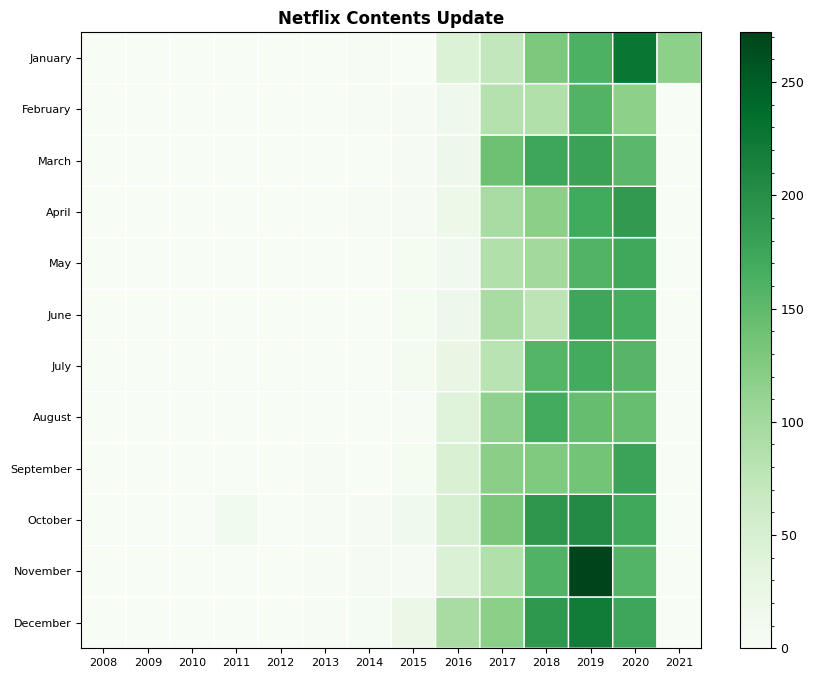

In [ ]:
plt.figure(figsize=(10, 8), dpi=100)
plt.pcolor(pt, cmap='Greens', edgecolors='white', linewidths=1)
plt.xticks(np.arange(0.5, len(pt.columns), 1), pt.columns, fontsize=8)
plt.yticks(np.arange(0.5, len(pt.index), 1), pt.index, fontsize=8)

plt.title('Netflix Contents Update', fontsize=12, fontweight='bold')
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=9)
cbar.ax.minorticks_on()
plt.show()

Здесь мы можем увидеть наиболее свободные периоды для релиза собственного контента

# Перейдем к анализу фильмов
Посмотрим на рейтинги и даты их создания

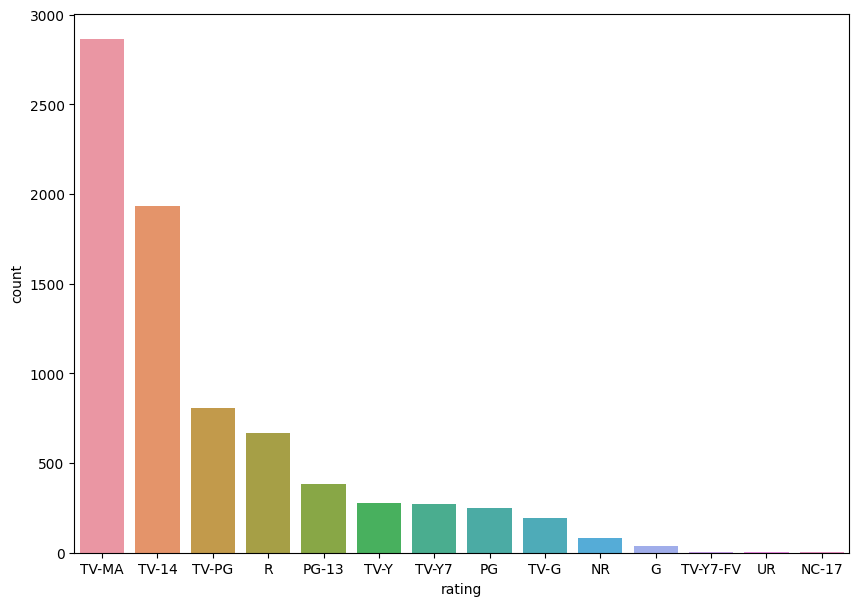

In [ ]:
plt.figure(figsize = (10, 7))
ax = sns.countplot(x=df['rating'], data = movies, order = df['rating'].value_counts().index[:15])

Здесь мы видим три самых популярных рейтинга фильмов

Text(0, 0.5, 'release date')

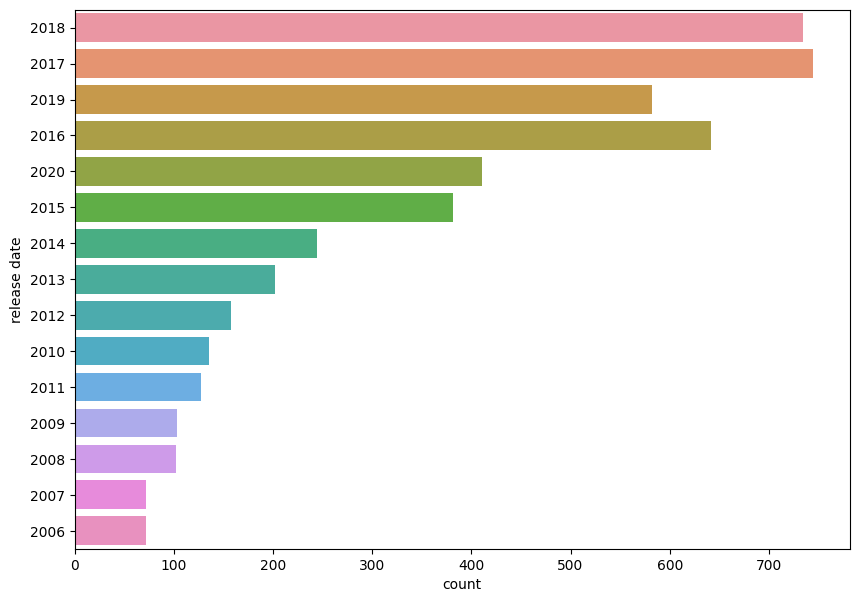

In [ ]:
plt.figure (figsize = (10, 7))
ax = sns.countplot(y = 'release_year', data = movies, order = df['release_year'].value_counts().index[:15])
ax.set_ylabel('release date')

## Посмотрим какие страны чаще всего выпускают фильмы
Заполним пропуски на 'country unknown'

In [ ]:
movies['country'] = movies['country'].fillna('country_unknown')

<ipython-input-18-8fa531779610>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
movies['country'].value_counts()

United States                                                   1850
India                                                            852
country_unknown                                                  230
United Kingdom                                                   193
Canada                                                           118
                                                                ... 
United Kingdom, Denmark, Canada, Croatia                           1
United States, South Korea                                         1
Kenya, United States                                               1
India, Turkey                                                      1
Sweden, Czech Republic, United Kingdom, Denmark, Netherlands       1
Name: country, Length: 591, dtype: int64

In [ ]:
c_dict = {}

def counter (l, d): #определим небольшую функцию она нам еще не раз понадобится
  listed = list(l)
  for i in listed:
    i = i.replace(' ', '')
    i = i.split(',')
    for j in i:
      if j in d.keys():
        d[j] += 1
      else:
        d[j] =1
  return d

counter(movies['country'], c_dict)

{'Mexico': 101,
 'Singapore': 18,
 'UnitedStates': 2431,
 'Egypt': 97,
 'India': 915,
 'Thailand': 43,
 'Nigeria': 68,
 'Norway': 20,
 'Iceland': 7,
 'UnitedKingdom': 467,
 'SouthKorea': 55,
 'Italy': 67,
 'Canada': 286,
 'Indonesia': 77,
 'Romania': 12,
 'Spain': 158,
 'Turkey': 80,
 'SouthAfrica': 44,
 'France': 265,
 'Portugal': 4,
 'country_unknown': 230,
 'HongKong': 97,
 'China': 102,
 'Germany': 157,
 'Argentina': 64,
 'Serbia': 7,
 'Denmark': 31,
 'Poland': 28,
 'Japan': 103,
 'Kenya': 5,
 'NewZealand': 20,
 'Pakistan': 20,
 'Australia': 84,
 'Taiwan': 15,
 'Netherlands': 37,
 'Philippines': 77,
 'UnitedArabEmirates': 33,
 'Brazil': 59,
 'Iran': 4,
 'Belgium': 74,
 'Israel': 18,
 'Uruguay': 13,
 'Bulgaria': 9,
 'Chile': 21,
 'Colombia': 17,
 'Algeria': 2,
 'SovietUnion': 3,
 'Sweden': 29,
 'Malaysia': 18,
 'Ireland': 28,
 'Luxembourg': 10,
 'Austria': 10,
 'Peru': 10,
 'Senegal': 2,
 'Switzerland': 16,
 'Ghana': 4,
 'SaudiArabia': 6,
 'Armenia': 1,
 'Jordan': 7,
 'Mongolia': 1,

In [ ]:
del c_dict['']

In [ ]:
def sorter (x):
  return sorted(x.items(), key=lambda item: x[item[0]], reverse = True)[:25]

<Axes: >

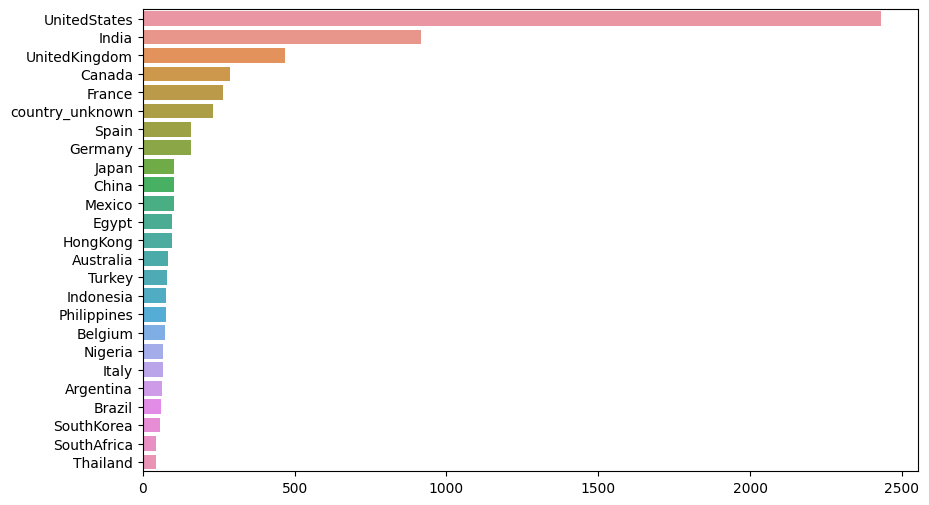

In [ ]:
names = [name for name, val in sorter(c_dict)]
values = [val for name, val in sorter(c_dict)]

plt.figure(figsize = (10, 6))
sns.barplot (y = names, x = values)

## Посмотрим на продолжительность фильмов

In [ ]:
movies['duration']

1        93 min
2        78 min
3        80 min
4       123 min
6        95 min
         ...   
7781     88 min
7782     99 min
7783    111 min
7784     44 min
7786     90 min
Name: duration, Length: 5377, dtype: object

In [ ]:
movies['duration'] = movies['duration'].str.replace(' min', '').astype(int)

<ipython-input-25-3faa3ef729bc>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='duration', ylabel='Density'>

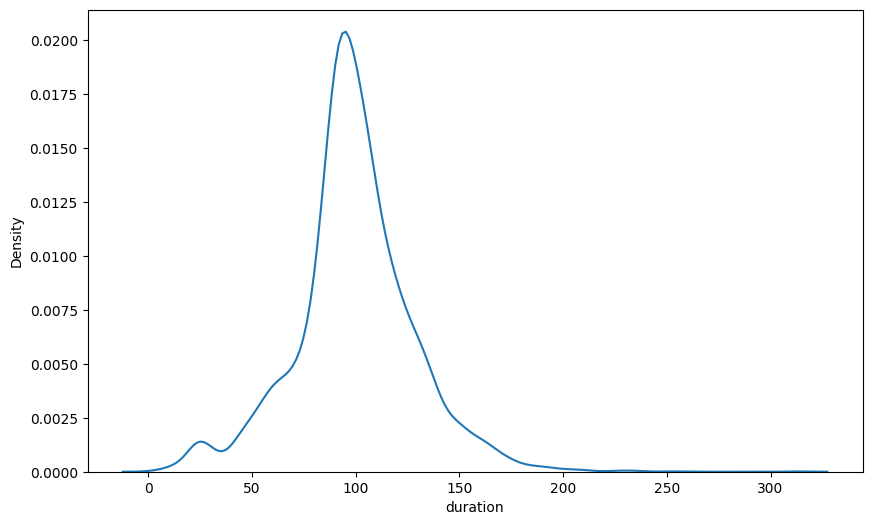

In [ ]:
plt.figure(figsize = (10, 6))
sns.kdeplot(x = movies['duration'], data = movies)

## Наиболее популярные жанры фильмов

In [ ]:
movies['listed_in']

1                            Dramas, International Movies
2                     Horror Movies, International Movies
3       Action & Adventure, Independent Movies, Sci-Fi...
4                                                  Dramas
6                     Horror Movies, International Movies
                              ...                        
7781                   Children & Family Movies, Comedies
7782                         Dramas, International Movies
7783       Dramas, International Movies, Music & Musicals
7784    Documentaries, International Movies, Music & M...
7786                      Documentaries, Music & Musicals
Name: listed_in, Length: 5377, dtype: object

In [ ]:
g_dict = {}
movies['listed_in']

counter(movies['listed_in'], g_dict)

{'Dramas': 2106,
 'InternationalMovies': 2437,
 'HorrorMovies': 312,
 'Action&Adventure': 721,
 'IndependentMovies': 673,
 'Sci-Fi&Fantasy': 218,
 'Thrillers': 491,
 'Documentaries': 786,
 'SportsMovies': 196,
 'Comedies': 1471,
 'RomanticMovies': 531,
 'Movies': 56,
 'Music&Musicals': 321,
 'LGBTQMovies': 90,
 'Faith&Spirituality': 57,
 'Children&FamilyMovies': 532,
 'ClassicMovies': 103,
 'CultMovies': 59,
 'Stand-UpComedy': 329,
 'AnimeFeatures': 57}

In [ ]:
g_names = [name for name, val in sorter(counter(movies['listed_in'], g_dict))]
g_values = [val for name, val in sorter(counter(movies['listed_in'], g_dict))]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'InternationalMovies'),
  Text(0, 1, 'Dramas'),
  Text(0, 2, 'Comedies'),
  Text(0, 3, 'Documentaries'),
  Text(0, 4, 'Action&Adventure'),
  Text(0, 5, 'IndependentMovies'),
  Text(0, 6, 'Children&FamilyMovies'),
  Text(0, 7, 'RomanticMovies'),
  Text(0, 8, 'Thrillers'),
  Text(0, 9, 'Stand-UpComedy'),
  Text(0, 10, 'Music&Musicals'),
  Text(0, 11, 'HorrorMovies'),
  Text(0, 12, 'Sci-Fi&Fantasy'),
  Text(0, 13, 'SportsMovies'),
  Text(0, 14, 'ClassicMovies'),
  Text(0, 15, 'LGBTQMovies'),
  Text(0, 16, 'CultMovies'),
  Text(0, 17, 'Faith&Spirituality'),
  Text(0, 18, 'AnimeFeatures'),
  Text(0, 19, 'Movies')])

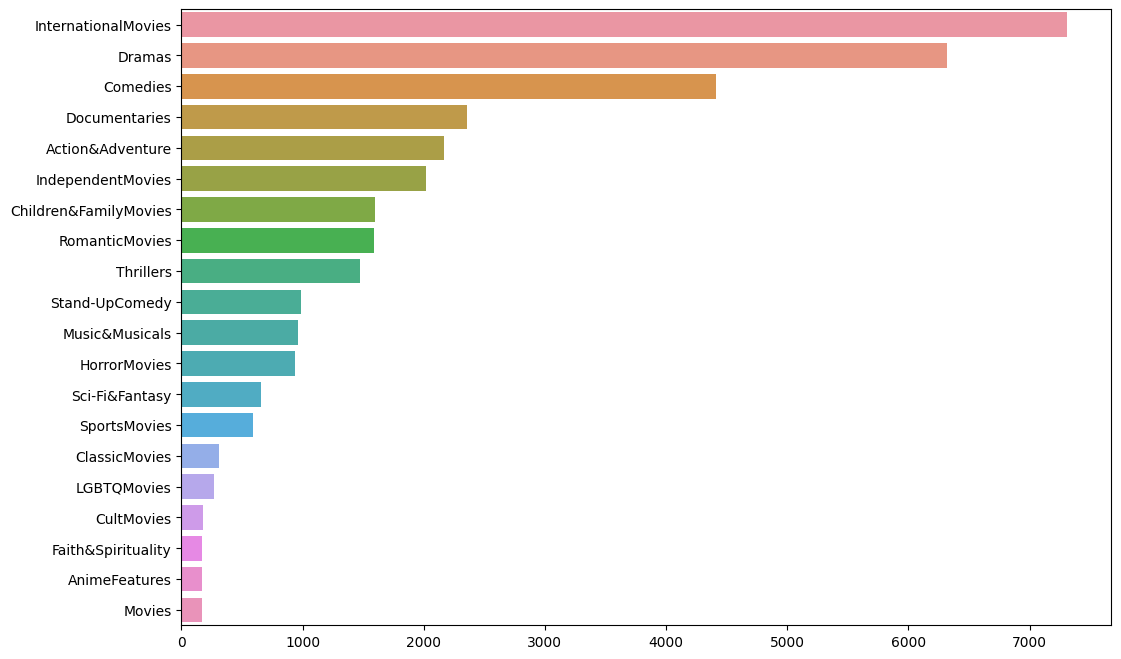

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x = g_values, y = g_names)
plt.yticks(fontsize = 10)

# Анализ сериалов
Рассмотрим страны которые чаще всего создавали сериалы

In [ ]:
tvshows['country'] = tvshows['country'].fillna('unknown_country')

<ipython-input-31-e5bbfa5d9ccd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
c_dict2 = {}

counter(tvshows['country'], c_dict2)

{'Brazil': 29,
 'Turkey': 28,
 'Poland': 8,
 'UnitedStates': 866,
 'Mexico': 53,
 'unknown_country': 277,
 'Japan': 184,
 'SouthKorea': 157,
 'UnitedKingdom': 256,
 'India': 75,
 'Canada': 126,
 'Italy': 23,
 'Spain': 57,
 'Australia': 60,
 'Taiwan': 70,
 'China': 45,
 'Germany': 42,
 'France': 84,
 'Singapore': 21,
 'Russia': 17,
 'Mauritius': 1,
 'SouthAfrica': 10,
 'Lebanon': 7,
 'Colombia': 28,
 'Argentina': 18,
 'Philippines': 1,
 'Finland': 4,
 'Netherlands': 8,
 'Chile': 5,
 'Thailand': 22,
 'Nigeria': 8,
 'SaudiArabia': 4,
 'Syria': 1,
 'Egypt': 13,
 'Kuwait': 3,
 'Belgium': 11,
 'Norway': 9,
 'Sweden': 10,
 'Denmark': 13,
 'Israel': 8,
 'Ireland': 12,
 'Iceland': 2,
 'Indonesia': 3,
 'Malaysia': 8,
 'NewZealand': 8,
 'CzechRepublic': 6,
 'Cuba': 1,
 'Austria': 1,
 'Greece': 2,
 'HongKong': 5,
 'Pakistan': 4,
 'Luxembourg': 1,
 'Jordan': 1,
 'Uruguay': 1,
 'Azerbaijan': 1,
 'WestGermany': 2,
 'PuertoRico': 1,
 'Malta': 1,
 'Senegal': 1,
 'Ukraine': 2,
 'Switzerland': 1,
 'Belar

In [ ]:
names = [name for name, val in sorter(counter(tvshows['country'], c_dict2))]
values = [val for name, val in sorter(counter(tvshows['country'], c_dict2))]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'UnitedStates'),
  Text(0, 1, 'unknown_country'),
  Text(0, 2, 'UnitedKingdom'),
  Text(0, 3, 'Japan'),
  Text(0, 4, 'SouthKorea'),
  Text(0, 5, 'Canada'),
  Text(0, 6, 'France'),
  Text(0, 7, 'India'),
  Text(0, 8, 'Taiwan'),
  Text(0, 9, 'Australia'),
  Text(0, 10, 'Spain'),
  Text(0, 11, 'Mexico'),
  Text(0, 12, 'China'),
  Text(0, 13, 'Germany'),
  Text(0, 14, 'Brazil'),
  Text(0, 15, 'Turkey'),
  Text(0, 16, 'Colombia'),
  Text(0, 17, 'Italy'),
  Text(0, 18, 'Thailand'),
  Text(0, 19, 'Singapore'),
  Text(0, 20, 'Argentina'),
  Text(0, 21, 'Russia'),
  Text(0, 22, 'Egypt'),
  Text(0, 23, 'Denmark'),
  Text(0, 24, 'Ireland')])

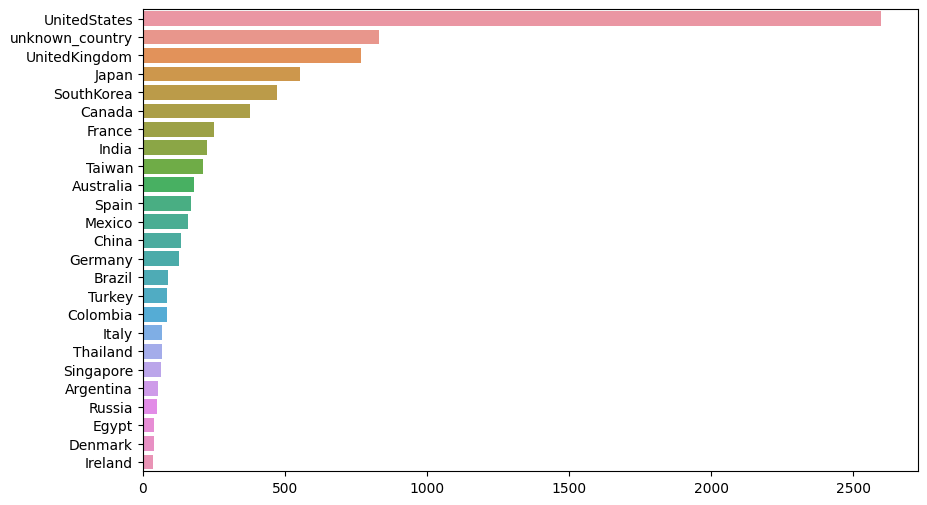

In [ ]:
plt.figure(figsize = (10, 6))
sns.barplot(y = names, x = values)
plt.yticks(fontsize = 10)

## Посмотрим на самую популярную длительность сериалов

In [ ]:
tvshows['duration']

0       4 Seasons
5        1 Season
11       1 Season
12       1 Season
16       1 Season
          ...    
7767     1 Season
7775     1 Season
7777    2 Seasons
7779     1 Season
7785     1 Season
Name: duration, Length: 2410, dtype: object

In [ ]:
tvshows['duration_int']=tvshows['duration'].str.replace('Season', '').str.replace('s', '').astype(int)
tvshows['duration_int']

<ipython-input-42-93ec3373228e>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



0       4
5       1
11      1
12      1
16      1
       ..
7767    1
7775    1
7777    2
7779    1
7785    1
Name: duration_int, Length: 2410, dtype: int64

Text(0.5, 0, 'seasons')

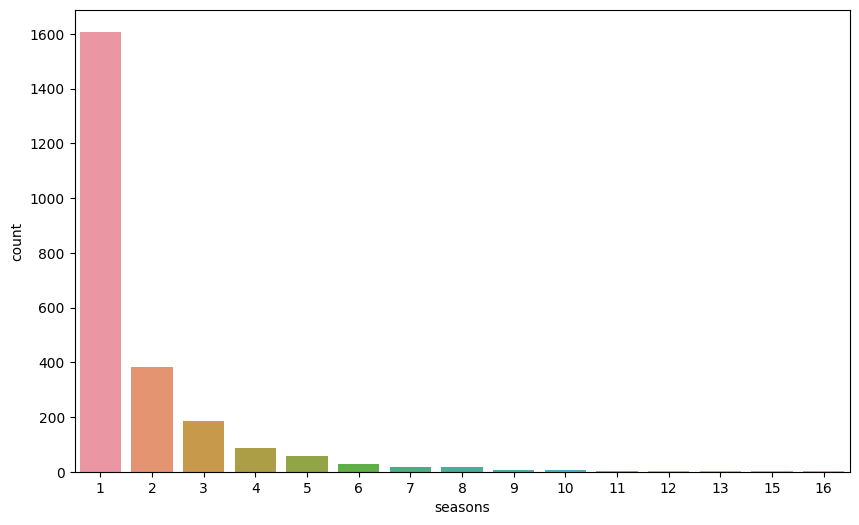

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x = tvshows['duration_int'], data = tvshows)
plt.xlabel('seasons')

Длительность в один сезон является наиболее популярной (у этого могут быть причины и помимо популярности)

##Выведем сериалы у которых больше всего сезонов

In [ ]:
tv_dur = tvshows[['title','duration_int']]

In [ ]:
top=tv_dur.sort_values(by = 'duration_int', ascending = False)[:25]

Text(0.5, 0, 'seasons')

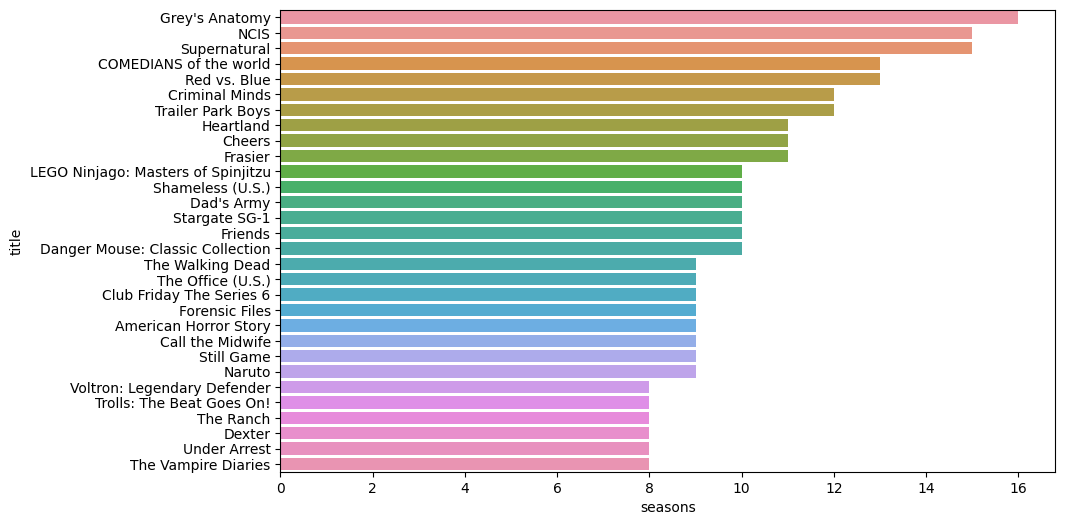

In [ ]:
plt.figure(figsize = (10, 6))
sns.barplot(y = top['title'], x = top['duration_int'])
plt.xlabel('seasons')

##Выведем сериалы у которых меньше всего сезонов

In [ ]:
bottom = tv_dur.sort_values(by = 'duration_int', ascending = True)[:30]

In [ ]:
fig = go.Figure(
    data = [
        go.Table(header = dict(values = ['Title', 'Seasons']),
                 cells = dict (values = [bottom['title'], bottom['duration_int']]))
])
fig.show()

# Перейдем к построению рекомендательных систем

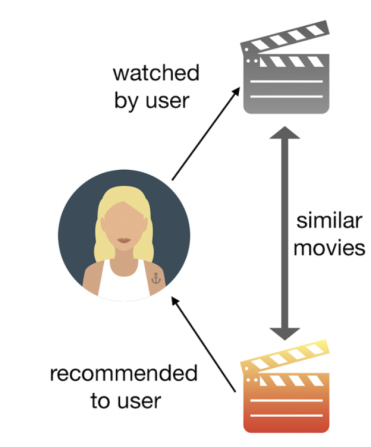





 *   Мешок слов
 *   TF-IDF <---

 Обратимся ко второму методу, который является более точным чем мешок слов (так как не учитывает вспомогательные слова, союзы и т.д.)





In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer['description']

In [ ]:
movies['description'].isna().sum()

0

In [ ]:
Tfidf = TfidfVectorizer(stop_words = 'english')
Tfidf_matrix = Tfidf.fit_transform(movies['description']) #обучаем и переводим в вектор (каждый фильм - вектор)



##Давать рекомендации мы будем опираясь на косинусную похожесть (вычисление угла между векторами)



In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

Создадим матрицу с вещественными значениями

In [ ]:
cosine_sim = cosine_similarity(Tfidf_matrix, Tfidf_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.09305242,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.07593931, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.07593931, ..., 1.        , 0.        ,
        0.        ],
       [0.09305242, 0.        , 0.        , ..., 0.        , 1.        ,
        0.02580113],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02580113,
        1.        ]])

In [ ]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()
indices

title
7:19                                          1
23:59                                         2
9                                             3
21                                            4
122                                           6
                                           ... 
Zoom                                       7781
Zozo                                       7782
Zubaan                                     7783
Zulu Man in Japan                          7784
ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS    7786
Length: 5377, dtype: int64

Создадим дата фрейм с нашими значениями похожести

In [ ]:
cosine_df = pd.DataFrame(cosine_sim)

cosine_df.columns = indices.index

cosine_df['title'] = indices.index
cosine_df = cosine_df.set_index('title')

cosine_df

title,7:19,23:59,9,21,122,187,706,1920,1922,"2,215",...,Zoé: Panoramas,Zodiac,Zokkomon,Zombieland,Zoo,Zoom,Zozo,Zubaan,Zulu Man in Japan,ZZ TOP: THAT LITTLE OL' BAND FROM TEXAS
title,,,,,,,,,,,,,,,,,,,,,
7:19,1.000000,0.0,0.000000,0.000000,0.0,0.027618,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.016381,0.000000,0.000000,0.093052,0.000000
23:59,0.000000,1.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.042022,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.0,1.000000,0.029333,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.023371,0.000000,0.000000,0.000000,0.075939,0.000000,0.000000
21,0.000000,0.0,0.029333,1.000000,0.0,0.037268,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
122,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.041665,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zoom,0.016381,0.0,0.000000,0.000000,0.0,0.015344,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
Zozo,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,1.000000,0.022703,0.000000,0.000000
Zubaan,0.000000,0.0,0.075939,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.022703,1.000000,0.000000,0.000000


Напишем функцию, которая будет выдавать наиболее похожие фильмы к фильму клиента

In [ ]:
def recomendations (title, cosine_sim = cosine_df):
  idx = indices[title]
  scores = list(enumerate(cosine_df.loc[title])) #берем значения похожести

  scores = sorted(scores, key = lambda x: x[1], reverse = True)[:11] #сортируем

  m_indices = [i[0] for i in scores] #получаем индексы фильмов
  return movies['title'].iloc[m_indices] #возвращаем названия

##Проверяем получившуюся функцию

In [ ]:
recomendations('Zoom')

7781                        Zoom
5753                Spider-Man 3
4034                      Menahi
962             Black Site Delta
878            Beyond the Clouds
7061          Thorne: Sleepyhead
7180           Train of the Dead
7115            To Be of Service
886               Bhangra Paa Le
738     Barbie in Princess Power
4271                   Mugamoodi
Name: title, dtype: object

In [ ]:
movies[movies['title'] == 'Zoom'].description.iloc[0]

'Dragged from civilian life, a former superhero must train a new crop of youthful saviors when the military preps for an attack by a familiar villain.'

In [ ]:
movies[movies['title'] == 'Spider-Man 3'].description.iloc[0]

'The seemingly invincible Spider-Man goes up against an all-new crop of villains in the third installment of the blockbuster adventure series.'

In [ ]:
movies[movies['title'] == 'Menahi'].description.iloc[0]

'A stranger to civilian life, a young Saudi farmer travels to Dubai, where he experiences a series of hilarious misadventures.'

In [ ]:
movies[movies['title'] == 'Black Site Delta'].description.iloc[0]

'After discovering that their secret military prison is under attack by terrorists, a ragtag group of inmates does their best to neutralize the enemy.'

Все работает!